<a href="https://colab.research.google.com/github/Samarth-991/Licence_plate-Detection/blob/main/LicencePlate_Detection%2BOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle
# !pip install -U PyYAML
# ! pip install git+git://github.com/jaidedai/easyocr.git
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d andrewmvd/car-plate-detection --force
# ! pip install split-folders
# ! unzip /content/car-plate-detection.zip
# ! mkdir car_plate_data
# ! mv images /content/car_plate_data 
# ! mv  annotations /content/car_plate_data
# !mkdir /content/car_plate_data/labels

!pip install onnxruntime
!pip install git+git://github.com/jaidedai/easyocr.git
# # Clone YOLOv5 code
# !git clone https://github.com/ultralytics/yolov5.git

     |████████████████████████████████| 4.5 MB 11.9 MB/s 
  Cloning git://github.com/jaidedai/easyocr.git to /tmp/pip-req-build-r7jbjuue
  Running command git clone -q git://github.com/jaidedai/easyocr.git /tmp/pip-req-build-r7jbjuue
  Created wheel for easyocr: filename=easyocr-1.4-py3-none-any.whl size=63624839 sha256=1cd996047752eca080ed67acb01d5b39ff586150e9f496923c40ad7412a66cb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-h6rhtqev/wheels/e4/17/25/2d203d4a2ecdb8b4d05e4cef1fed51634287906dfafee45701
Successfully built easyocr


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
import os
import cv2
import time
from glob import glob
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import Image
from matplotlib import pyplot as plt
import easyocr

en_reader = easyocr.Reader(['en']) # need to run only once to load model into memory
# arabic_reader = easyocr.Reader(['ar',en])

## convert XML data to Yolov5 

In [ ]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()

def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    save_file(img_xml_file, [img_w, img_h], img_box)

def decode_img(img,shape=(320,320),channel = 3):
    resized = cv2.resize(img, shape, interpolation=cv2.INTER_LINEAR)
    img = np.transpose(resized, (2, 0, 1)).astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

def post_processing(img,output, conf_thresh=0.3, nms_thresh=0.5 ):

    # anchors = [12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]
    # num_anchors = 9
    # anchor_masks = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    # strides = [8, 16, 32]
    # anchor_step = len(anchors) // num_anchors

    # [batch, num, 1, 4]
    box_array = output[0]
    # [batch, num, num_classes]
    confs = output[1]

    t1 = time.time()

    if type(box_array).__name__ != 'ndarray':
        box_array = box_array.cpu().detach().numpy()
        confs = confs.cpu().detach().numpy()

    num_classes = confs.shape[2]

    # [batch, num, 4]
    box_array = box_array[:, :, 0]

    # [batch, num, num_classes] --> [batch, num]
    max_conf = np.max(confs, axis=2)
    max_id = np.argmax(confs, axis=2)

    t2 = time.time()

    bboxes_batch = []
    for i in range(box_array.shape[0]):
       
        argwhere = max_conf[i] > conf_thresh
        l_box_array = box_array[i, argwhere, :]
        l_max_conf = max_conf[i, argwhere]
        l_max_id = max_id[i, argwhere]

        bboxes = []
        # nms for each class
        for j in range(num_classes):

            cls_argwhere = l_max_id == j
            ll_box_array = l_box_array[cls_argwhere, :]
            ll_max_conf = l_max_conf[cls_argwhere]
            ll_max_id = l_max_id[cls_argwhere]

            keep = nms_cpu(ll_box_array, ll_max_conf, nms_thresh)
            
            if (keep.size > 0):
                ll_box_array = ll_box_array[keep, :]
                ll_max_conf = ll_max_conf[keep]
                ll_max_id = ll_max_id[keep]

                for k in range(ll_box_array.shape[0]):
                    bboxes.append([ll_box_array[k, 0], ll_box_array[k, 1], ll_box_array[k, 2], ll_box_array[k, 3], ll_max_conf[k], ll_max_conf[k], ll_max_id[k]])
        
        bboxes_batch.append(bboxes)

    t3 = time.time()

    print('-----------------------------------')
    print('       max and argmax : %f' % (t2 - t1))
    print('                  nms : %f' % (t3 - t2))
    print('Post processing total : %f' % (t3 - t1))
    print('-----------------------------------')
    
    return bboxes_batch


def nms_cpu(boxes, confs, nms_thresh=0.4, min_mode=False):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = confs.argsort()[::-1]

    keep = []
    while order.size > 0:
        idx_self = order[0]
        idx_other = order[1:]

        keep.append(idx_self)

        xx1 = np.maximum(x1[idx_self], x1[idx_other])
        yy1 = np.maximum(y1[idx_self], y1[idx_other])
        xx2 = np.minimum(x2[idx_self], x2[idx_other])
        yy2 = np.minimum(y2[idx_self], y2[idx_other])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        if min_mode:
            over = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            over = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = np.where(over <= nms_thresh)[0]
        order = order[inds + 1]
    
    return np.array(keep)

def class_colors(names):

    return {name: (
        np.random.randint(0, 255),
        np.random.randint(0, 255),
        np.random.randint(0, 255)) for name in names}

def decode_boxes(bboxes,width,height):
    cords = None
    for i in range(len(boxes[0])):
        box = boxes[0]
        x1 = int(box[i][0] * width)
        y1 = int(box[i][1] * height)
        x2 = int(box[i][2] * width)
        y2 = int(box[i][3] * height)
        cords = (x1,y1,x2,y2)
    return cords

def plot_boxes_cv2(img, boxes, savename=None, class_names=None, color=None,save_cords=None):
    img = np.copy(img)
    color = class_colors(class_names)
    width = img.shape[1]
    height = img.shape[0]
    cords= decode_boxes(boxes,width,height)
    for i in range(len(boxes[0])):
        box = boxes[0]
        if cords is not None :
            if class_names:
                cls_conf = box[i][5]
                cls_id = box[i][6]
                cls_label = class_names[cls_id]
                img = cv2.putText(img, class_names[cls_id], (cords[0]-5, cords[1]-5), cv2.FONT_HERSHEY_SIMPLEX,2, color[cls_label], 3)
            img = cv2.rectangle(img, (cords[0], cords[1]), (cords[2], cords[3]),color[cls_label], 5)
    return img ,cords

def detect(img_src,model):
    input_name = model.get_inputs()[0].name
    outputs = model.get_outputs()
    output_names = list(map(lambda output: output.name, outputs))
    detections = model.run(output_names, {input_name: img_src})
    boxes = post_processing(img_src,detections)
    return boxes 

def select_colorspace(img_alpr):
    color_val='Neutral'
    color_space = ['Red','Green','Blue','White']
    kmeans=KMeans(n_clusters=3)
    
    img_alpr_flat=img_alpr.reshape((img_alpr.shape[1]*img_alpr.shape[0],3))
    
    s=kmeans.fit(img_alpr_flat)
    centroid=kmeans.cluster_centers_
    diff = [max(sets)-min(sets) for sets in centroid]
    if max(diff)>15:
        color_val = color_space[np.argmax(centroid[np.argmax(diff)])]
    return color_val

## Train data using Yolov5

In [ ]:
# %cd /content/yolov5
# ! python train.py --img 416 --batch 8 --epochs 300 --data /content/alpr.yaml --cfg models/yolov5s.yaml

## Run Detection Validation

In [ ]:
# !python detect.py --source /content/Dataset/test_dubai --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

## Detect using ONNX Model for Deployment

In [ ]:
import onnxruntime

onnx_path = '/content/drive/MyDrive/Colab_Notebooks/Licence-Plate/yolov4_1_3_320_320_static.onnx'
imgs_files = glob('/content/drive/MyDrive/Colab_Notebooks/Licence-Plate/vehicleplates/*.jpg')
session = onnxruntime.InferenceSession(onnx_path)
IN_IMAGE_H = session.get_inputs()[0].shape[1]
IN_IMAGE_W = session.get_inputs()[0].shape[2]
IN_DEPTH = session.get_inputs()[0].shape[3] 
IMG_SHAPE = (IN_IMAGE_H,IN_IMAGE_W,IN_DEPTH)
print("Netowrk shape {}x{}x{}".format(IN_IMAGE_H,IN_IMAGE_W,IN_DEPTH))

Netowrk shape 3x320x320


/content/drive/MyDrive/Colab_Notebooks/Licence-Plate/vehicleplates/IMG-20210610-WA0048.jpg
-----------------------------------
       max and argmax : 0.000112
                  nms : 0.000228
Post processing total : 0.000341
-----------------------------------
input image shape (1, 3, 320, 320)


<Figure size 1080x1080 with 0 Axes>

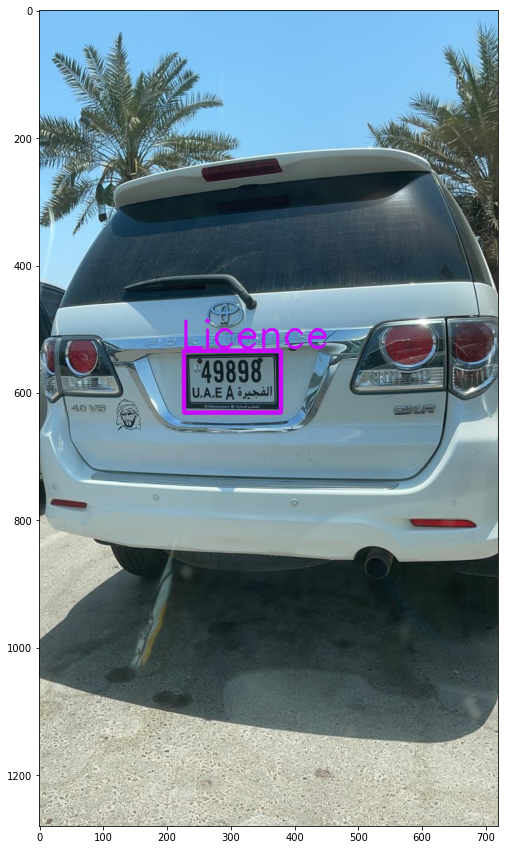

In [ ]:
plt.figure(figsize=(15,15))
img_path = imgs_files[np.random.randint(0,len(imgs_files))]
print(img_path)
input_img = cv2.imread(img_path)
input_img= cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

img_in = decode_img(input_img,shape=(320,320))
boxes = detect(img_in,session)
print("input image shape {}".format(img_in.shape))

out_img ,cords = plot_boxes_cv2(input_img,boxes,class_names=['Licence'])
plt.figure(figsize=(15,15))
plt.imshow(out_img)

['49898', 'UAEAisl']
49898
UAE


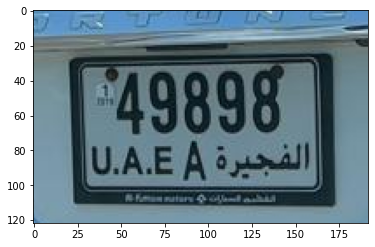

In [ ]:
import re
pattern = re.compile(r'\s+')

img_alpr = input_img[cords[1]-20:cords[3]+5,cords[0]-20:cords[2]+20]
results = en_reader.readtext(img_alpr)
text_en = [re.sub(pattern," ",r[-2]) for r in results if r[-1] > 0.3]

print(text_en)
for text in text_en :
    if ('UAE' in text ) or ('AD' in text):
        print(text[:3])
    elif text.isdecimal():
        print(text)



# for r in results2:
#     if r[-1]>0.2:
#         print(r[-2])
#     # img = cv2.polylines(img, [points], True, (255, 0, 0), 1)
plt.imshow(img_alpr)
# select_colorspace(img_alpr)

[([[40, 26], [152, 26], [152, 80], [40, 80]], '49898', 0.9979460707711608), ([[28, 70], [165, 70], [165, 102], [28, 102]], '(UAEAixsall', 0.3739502424399486)]


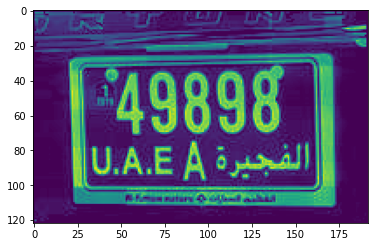

In [ ]:
from skimage.segmentation import clear_border

def enhance_plate(img,keep=5):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 10))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
    blackhat = clear_border(blackhat)
    # roi = cv2.threshold(blackhat, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    results = en_reader.readtext(blackhat)
    print (results)
    plt.imshow(blackhat)

enhance_plate(img_alpr)

In [ ]:
!pip install ocrspace

  Created wheel for ocrspace: filename=ocrspace-2.3.0-py3-none-any.whl size=2321 sha256=540d51c6557f5b0a7bd0537a20a8e0d72c16bf0964299a0cd264cfbd825a2acd
  Stored in directory: /root/.cache/pip/wheels/40/0a/f2/8694d1950b3aa8eec0ac98de41a61f7d8b18004cbb64bd8b98
Successfully built ocrspace
